In [1]:
import json
import numpy as np 
import tensorflow as tf
import os
import cv2
np.random.seed(4)
from numpy import mean
from numpy import std

from tqdm import tqdm
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import train_test_split

from metrics import evaluate_model_simple

In [2]:
tf.__version__

'2.5.0'

# Data Overview


The goal is to create a HAR model that's trained on keypoints. 

Each frame of category each has been infered via keypoint detector and the result has been stored in <videofile.mp4.json> in the train and val folders respectively.

### Data Loading


In [34]:
min_det_threshold = 15 # To remove noise(videos with little to no frames with keypoints), we will set some minimum detection threshold

In [35]:
data_dir = "./inferences_/"
train_dir = "./trimmed/train/"

cat = []
data = []



for k,cls in enumerate(tqdm(os.listdir(train_dir))):
    
    for vid in os.listdir(os.path.join(train_dir, cls)):
        
        video_path = os.path.join(os.path.join(train_dir, cls),vid)
        cap = cv2.VideoCapture(video_path)

        
        f = open(os.path.join(data_dir, vid+"_data_val.json"))
        frame_data = json.load(f)
        
        frame_ls = []
        
        for frame in range(len(frame_data["filename"]["keypoints"])):
            keypts_ls = []

            for det in ((frame_data["filename"]["keypoints"][frame])):
#                 print((det))
#                 dist = (det[0]**2+det[1]**2)**0.5

                keypts_ls.append(det[0])
                keypts_ls.append(det[1])
            
            frame_ls.append(keypts_ls)
        
#         print(f"Total Frames shape {vid} : {np.array(frame_ls).shape}")

            

        if len(frame_ls) > min_det_threshold:
            data.append(frame_ls)
            cat.append(k)



100%|███████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.27s/it]


In [36]:
from matplotlib import pyplot as plt
from collections import Counter

classes = os.listdir(train_dir)
class_counts_train = Counter(cat)
print(class_counts_train)

class_weights = np.array([1/i for i in class_counts_train.values()])
# class_weights[3], class_weights[4] = class_weights[3]*1.15, class_weights[4]*1.25 
print(class_weights)

Counter({2: 105, 1: 89, 0: 81, 3: 78, 4: 56})
[0.01234568 0.01123596 0.00952381 0.01282051 0.01785714]


In [37]:
val_data_dir = "./val_inf/"
val_dir = "./trimmed/val/"

val_cat = []
val_data = []



for k,cls in enumerate(tqdm(os.listdir(val_dir))):
    
    for vid in os.listdir(os.path.join(val_dir, cls)):

        f = open(os.path.join(val_data_dir, vid+"_data_val.json"))
        frame_data = json.load(f)
        
        frame_ls = []
        
        for frame in range(len(frame_data["filename"]["keypoints"])):
            keypts_ls = []

            for det in ((frame_data["filename"]["keypoints"][frame])):
#                 print((det))
#                 dist = (det[0]**2+det[1]**2)**0.5
                keypts_ls.append(det[0])
                keypts_ls.append(det[1])
            
            frame_ls.append(keypts_ls)
   

        if len(frame_ls) > min_det_threshold:
            val_data.append(frame_ls)
            val_cat.append(k)


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 27.31it/s]


In [38]:
class_counts_val = Counter(val_cat)
print(class_counts_val)

Counter({0: 29, 2: 28, 1: 27, 3: 26, 4: 21})


##### Data format for X: [N, F,C]
Where:
- N : Number of videos
- F : Frames
- C : Cordinates (x,y)

###### Y: [cat(int)]

## One Hot Encoding
Vectorize the target 

Y[int] > Y[Vector]

In [39]:
category = np.array(cat).reshape(-1,1)
enc = OneHotEncoder()
enc.fit(category)
onehotlabels = enc.transform(category).toarray()  

y_val =  enc.transform(np.array(val_cat).reshape(-1,1)).toarray() 



print(f"y_train shape:  {onehotlabels.shape}\t y_val shape: {y_val.shape}")

y_train shape:  (409, 5)	 y_val shape: (131, 5)


## Model Hyperparameters

- max_seq_length: The maximum length of sequence while padding and trimming
- n_steps
- n_length
- holdout_ratio : Ratio of data to be ignored
- num_conv_filter: Number of filters in convlstm layer
- filter_size: The size of the filters

In [40]:
max_seq_length= 50
n_steps, n_length = 5, 10
test_size = 0.001
verbose, epochs, batch_size = 0, 65, 200
num_conv_filter = 64
filter_size = (1,9)


In [41]:
from sklearn.model_selection import train_test_split

sc = StandardScaler()


def load_dataset():

    X = sequence.pad_sequences(data, maxlen=max_seq_length)
    X_scaled = sc.fit_transform(X.reshape(-1,X.shape[1]*X.shape[2]))
    X_scaled = X_scaled.reshape(X.shape)
    
    X_val = sequence.pad_sequences(val_data, maxlen=max_seq_length)
    X_val_scaled = sc.fit_transform(X_val.reshape(-1,X_val.shape[1]*X_val.shape[2]))
    X_val_scaled = X_val_scaled.reshape(X_val.shape)
    
    
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, onehotlabels ,test_size=test_size)

    return X_train, y_train, X_val_scaled, y_val

In [42]:

def generate_sample_weights(training_data, class_weights): 
    sample_weights = [class_weights[np.where(one_hot_row==1)[0][0]] for one_hot_row in training_data]
    return np.asarray(sample_weights)


def plot_history(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    

In [43]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD


def get_model(trainX, trainy, testX, testy):
    # define model
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    # reshape into subsequences (samples, time steps, rows, cols, channels)
    trainX = trainX.reshape((trainX.shape[0], n_steps, 1, n_length, n_features))
    testX = testX.reshape((testX.shape[0], n_steps, 1, n_length, n_features))
    # define model
    model = Sequential()
    model.add(ConvLSTM2D(filters=num_conv_filter, kernel_size=filter_size, activation='relu',
                         input_shape=(n_steps, 1, n_length, n_features),return_sequences = True))
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(n_outputs, activation='softmax'))

#     opt = SGD(lr=0.01, momentum=0.9)
    model.compile(loss=tf.keras.losses.CategoricalHinge(), optimizer="adam", metrics=['accuracy'])
    # fit network
    hist = model.fit(trainX, trainy, epochs=epochs,validation_split=0.2, batch_size=batch_size, verbose=verbose,sample_weight=generate_sample_weights(trainy, class_weights) )
    plot_history(hist)
    _, accuracy = model.evaluate(testX, testy, batch_size=1, verbose=0)
    y_pred = model.predict(testX)
        # evaluate model
    return  model, accuracy, y_pred, testy

In [44]:
import sklearn
def performance(y_pred, y_test):
    
    truth_argmax = np.argmax(y_test, axis=1)
    pred_argmax = np.argmax(y_pred, axis=1)
    
    test_cm = sklearn.metrics.confusion_matrix(truth_argmax, pred_argmax)
    test_f1 = sklearn.metrics.f1_score(truth_argmax, pred_argmax, average='macro')
    test_precision = sklearn.metrics.precision_score(truth_argmax, pred_argmax, average='macro')
    test_recall = sklearn.metrics.recall_score(truth_argmax, pred_argmax, average='macro')
    test_kappa = sklearn.metrics.cohen_kappa_score(truth_argmax, pred_argmax)

    test_f1_micro = sklearn.metrics.f1_score(truth_argmax, pred_argmax, average='micro')
    test_f1_weighted = sklearn.metrics.f1_score(truth_argmax, pred_argmax, average='weighted')
    
    print("Confusion Matrix:\n ", test_cm)
    print("F1 Score:\t", test_f1)
    print("F1 micro:\t", test_f1_micro)
    print("F1 weight:\t", test_f1_weighted)
    print("Precision:\t", test_precision)
    print("Recall:\t", test_recall)
        

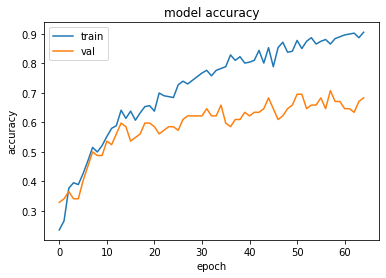

Best val-set accuracy so far: >#1: 57.252
Confusion Matrix:
  [[14  6  1  1  7]
 [ 2 19  1  2  3]
 [ 0  2 23  3  0]
 [ 0  2 10 12  2]
 [ 2  9  2  1  7]]
F1 Score:	 0.5542771412984179
F1 micro:	 0.5725190839694656
F1 weight:	 0.5655974229873856
Precision:	 0.5798798798798798
Recall:	 0.5605525381387451


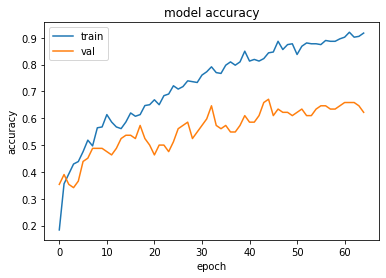

Best val-set accuracy so far: >#2: 61.069
Confusion Matrix:
  [[17  6  1  2  3]
 [ 5 15  1  2  4]
 [ 1  0 26  0  1]
 [ 1  2  5 17  1]
 [ 5  8  2  1  5]]
F1 Score:	 0.5845785440613026
F1 micro:	 0.6106870229007634
F1 weight:	 0.5991854581615045
Precision:	 0.5885610274041866
Recall:	 0.59245505452402


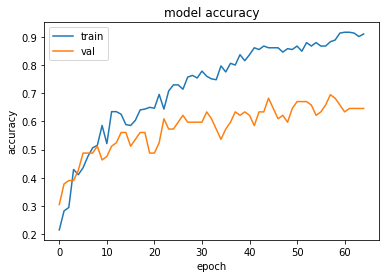

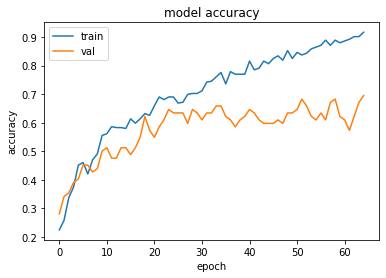

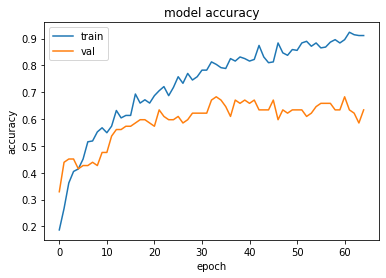

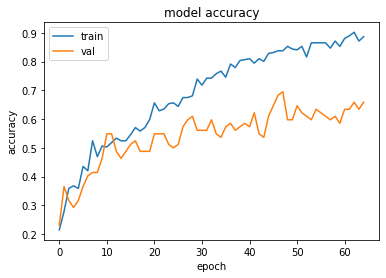

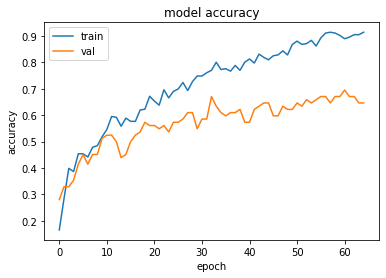

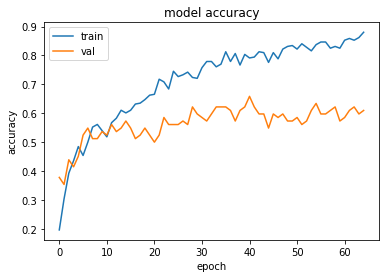

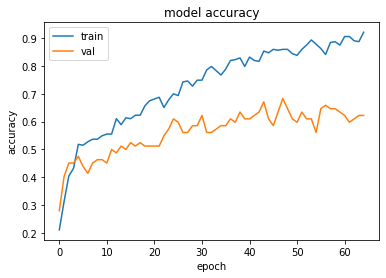

Best val-set accuracy so far: >#9: 61.832
Confusion Matrix:
  [[15  6  1  1  6]
 [ 4 16  2  2  3]
 [ 0  1 24  2  1]
 [ 2  1  6 16  1]
 [ 4  5  1  1 10]]
F1 Score:	 0.6088069636456733
F1 micro:	 0.6183206106870229
F1 weight:	 0.6148888185332412
Precision:	 0.612213938867083
Recall:	 0.6117103841241772


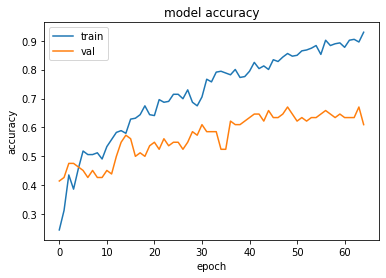

[57.251906394958496, 61.06870174407959, 53.43511700630188, 59.54198241233826, 60.30534505844116, 61.06870174407959, 57.251906394958496, 57.251906394958496, 61.83205842971802, 58.77862572669983]
Accuracy: 58.779% (+/-2.414)


In [45]:
def summarize_results(scores):
    print(scores)
    m, s = mean(scores), std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

def run_experiment(repeats=10):
    X_train, y_train, X_test, y_test = load_dataset()
    
    best_model = None
    best_acc = 0
    
    scores = list()
    for r in range(repeats):
        
        model, accuracy, y_pred, testy = get_model(X_train, y_train, X_test,y_test)
        score = accuracy * 100.0
        
        if score > best_acc:
            best_acc = score
            best_model = model
            
            print(f"Best val-set accuracy so far: {'>#%d: %.3f' % (r+1, score)}")
            performance(y_pred, testy)


        
        scores.append(score)

    summarize_results(scores)
    return best_model

# run the experiment
model = run_experiment()